# Behaviorial Cloning Project
## Thomas J. Chmielenski
### September 2017

This notebook is a utility notebook to help with experimenting and preprocessing the training set data.
Utility functions to create graphs, show images will be created and utilitized here.

Final executing code will be pushed to the model.py

### Read the driving_log.csv into memory

In [56]:
import os
import csv
import numpy as np


TEST_SIZE = 0.20
BATCH_SIZE = 32
NUM_EPOCHS = 3

samples = []
remove_zero_percentage = 0.95

def load_dataset(root_data_dir):
    global samples 
    csvfilename = root_data_dir + 'driving_log.csv'
    with open(csvfilename) as csvfile:
        reader = csv.reader(csvfile)
        
        for line in reader:
            # filter out 70% of the near zero steering angles to avoid high bias 
            center_angle = float(line[3])
            prob =  np.random.rand()
            if (abs(center_angle) < 0.01 and prob < remove_zero_percentage):
                continue
            samples.append(line)
    return samples

datasets = []
datasets.append("./data/data/")  #Udacity Training Set
datasets.append("./data/CenterLaneDriving/")  
datasets.append("./data/TeenagerDriver/")
datasets.append("./data/CounterClockwise/")

for ds in datasets:
    load_dataset(ds)

print("Number of samples =", len(samples))

Number of samples = 7317


In [2]:
### Debug Utilities

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def get_available_cpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']

print ("CPUs available")
print(get_available_cpus())
print ("GPUs available")
print(get_available_gpus())

CPUs available
['/cpu:0']
GPUs available
[]


In [4]:
### File Utilties

In [5]:
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def create_subDir (dir, sub_dir):
    new_path = os.path.join(dir, sub_dir)
    ensure_dir(new_path)
    return (new_path)

In [6]:
### Image Plot utilities

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


def saveImage(imageFilename, image):  
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ensure_dir(imageFilename)
    cv2.imwrite(imageFilename,RGB_img)

def displayImage(image):
        plt.imshow(image)
        plt.show()
    


In [8]:
### Image Methods

In [9]:
def flip_image (image, measurement):
    image_flipped = np.fliplr(image)
    measurement_flipped = -measurement
    return (image_flipped, measurement_flipped)

def colorCorrect_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size = TEST_SIZE)


### show sample data images

Z:\SDCar\Git\TJC-CarND-BehavioralTraining-P3\data\CenterLaneDriving\IMG\center_2017_09_02_11_29_56_595.jpg
Z:\SDCar\Git\TJC-CarND-BehavioralTraining-P3\data\CenterLaneDriving\IMG\left_2017_09_02_11_29_56_595.jpg
Z:\SDCar\Git\TJC-CarND-BehavioralTraining-P3\data\CenterLaneDriving\IMG\right_2017_09_02_11_29_56_595.jpg


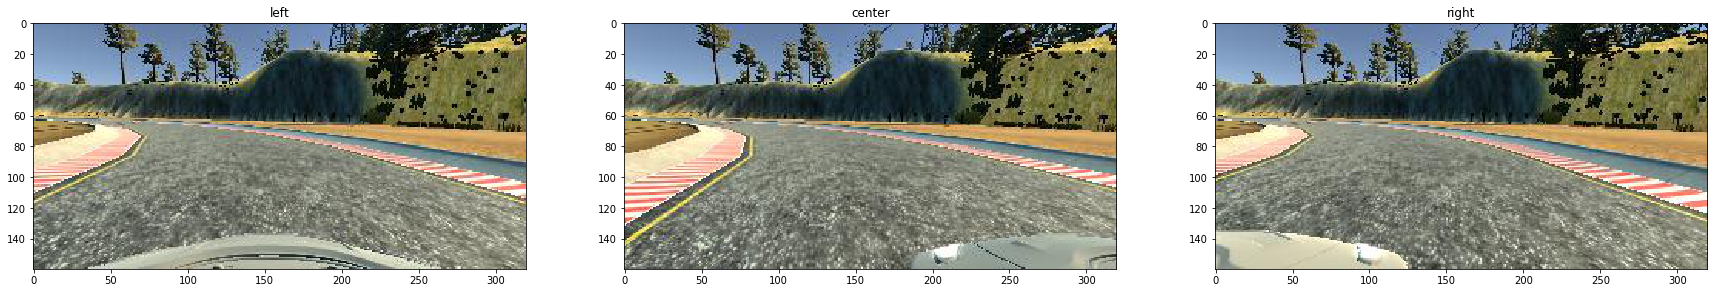

In [11]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

def showImagesHorizontally(data_row):

    labels =['left','center', 'right']
    plt.figure(figsize=(30,15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        
        name =  data_row[i].strip()
        print(name)
        image = cv2.imread(name)
        image = colorCorrect_image(image)
        plt.imshow(image)
        plt.title(labels[i])
        plt.subplots_adjust(hspace=0.5)
        
        
showImagesHorizontally(train_samples[0])
plt.savefig('output/left_center_right_images.png')
plt.show()

Z:\SDCar\Git\TJC-CarND-BehavioralTraining-P3\data\CenterLaneDriving\IMG\left_2017_09_02_11_29_56_595.jpg


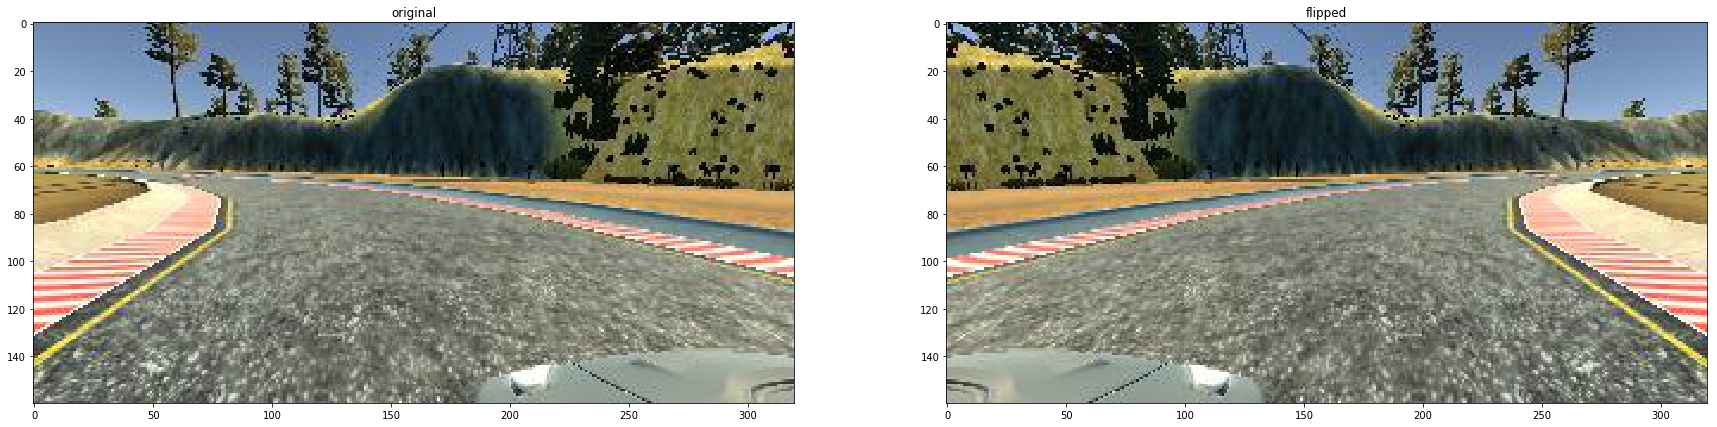

In [12]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

def show_image_flipped(image):
    plt.figure(figsize=(30,15))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('original')
    plt.subplots_adjust(hspace=0.5)
        
    plt.subplot(1, 2, 2)
    measurement = 0 # not needed for display
    flipped_image, measurement = flip_image (image, measurement)
    plt.imshow(flipped_image)
    plt.title('flipped')
    plt.subplots_adjust(hspace=0.5)
    
    plt.savefig('output/image_flipped.png')
    plt.show()    
        
# show the center image flipped
name = train_samples[0][1].strip()
print(name)
image = cv2.imread(name)
image = colorCorrect_image(image)
show_image_flipped(image)


In [13]:
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def generator(samples, batch_size = BATCH_SIZE):
    steering_correction_factor = 0.25
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                name = datasets[0] + 'IMG/'+ batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = colorCorrect_image(center_image)
                center_angle = float(batch_sample[3])
                angles.append(center_angle)
                
                #height, width, channels = center_image.shape
                #print (height, width, channels)
                
                # use left and right images, as well, applying a sterring_correction_factor
                # create adjusted steering measurements for the side camera images
                left_image = cv2.imread(name)
                left_image = colorCorrect_image(left_image)
                steering_left_angle = center_angle + steering_correction_factor
                images.append(left_image)
                angles.append(steering_left_angle)

                right_image = cv2.imread(name)
                right_imagee = colorCorrect_image(right_image)
                steering_right_angle = center_angle - steering_correction_factor
                images.append(right_image)
                angles.append(steering_right_angle)


            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size = BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size = BATCH_SIZE)



[ 0.          0.0617599   0.05219137 ...,  0.03171146  0.9322197   1.        ]


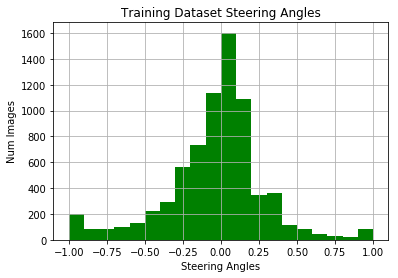

[  197.    86.    82.    98.   130.   222.   290.   563.   732.  1138.
  1603.  1092.   347.   361.   114.    84.    45.    28.    24.    81.]


In [57]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

steering_angles = np.array(samples)[:,3].astype(np.float)
print (steering_angles)

def plot_histogram(dataset, title, x_label, y_label, save_as_filename = None, color='green', num_bins=100):
    (n, bins, patches) = plt.hist(dataset, num_bins, color='green')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    if save_as_filename:
        plt.savefig(save_as_filename)
    plt.show()
    print (n)
    
plot_histogram(steering_angles, "Training Dataset Steering Angles", "Steering Angles", "Num Images", 
              "output/both_steering_angles_histogram.png", num_bins=20)



In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Lambda, Cropping2D, Flatten, Dense, MaxPooling2D, Dropout

In [ ]:
# first attempt
# Preprocess incoming data, centered around zero with small standard deviation 
model = Sequential()
model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160,320,3))) #normalize the data
model.add(Flatten())
model.add(Dense(1))

#model.summary()

In [ ]:
# second attempt - LeNet
#model = Sequential()
#model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160,320,3))) #normalize the data
#model.add(Cropping2D(cropping = ((55,25), (0,0))))  # ((PixelsFromTop. FromBottom), (FromLeft,FromRight))
#model.add(Convolution2D(6,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Convolution2D(16,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(120))
#model.add(Dropout(0.5))
#model.add(Dense(84))
#model.add(Dropout(0.5))
#model.add(Dense(1))

In [ ]:
# third attempt - NVidia

In [ ]:
# print out model summary
model.summary()

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, 
            samples_per_epoch = len(train_samples), 
            validation_data = validation_generator, 
            nb_val_samples = len(validation_samples), 
            nb_epoch = NUM_EPOCHS, verbose  = 2)

model.save('model_6N.h5')

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
print (len(validation_samples))

In [ ]:
print (len(train_samples))

